In [1]:
# Create connection to spark cluster
from pyspark.sql import SparkSession

spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.118:7077") \
        .appName("hadoop_example")\
        .config("spark.dynamicAllocation.enabled", False)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.executor.cores",2)\
        .getOrCreate()

spark_context = spark_session.sparkContext

In [2]:
#load the data from the HDFS cluster.
rdd = spark_context.newAPIHadoopFile(
    'hdfs://192.168.2.118:9000/unzip_input/RC_2011-09',
    'org.apache.hadoop.mapreduce.lib.input.TextInputFormat',
    'org.apache.hadoop.io.LongWritable',
    'org.apache.hadoop.io.Text'
)
# for weak scalcability test increase no_duplicates otherwise keep no_duplicates = 0
# no_duplicates = 0 for one node 
# no_duplicates = 1 for two nodes
# no_duplicates = 2 for three nodes
# no_duplicates = 3 for four nodes
no_duplicates=0
for i in range(no_duplicates):
    rdd += spark_context.newAPIHadoopFile(
    'hdfs://192.168.2.118:9000/unzip_input/RC_2011-09',
    'org.apache.hadoop.mapreduce.lib.input.TextInputFormat',
    'org.apache.hadoop.io.LongWritable',
    'org.apache.hadoop.io.Text'
    )

In [3]:
from operator import add
import re

# Convert each line of the file into json format and then filter out lines only from the subbredit AskReddit
import json
rdd_askReddit = rdd\
    .map(lambda line: json.loads(line[1]))\
    .filter(lambda line: line["subreddit"] == "AskReddit")

# Slit the comments on cahracters that aren't letters, numbers or '. 
# Then maps all words into one list insted of one for every comment.
# Removes words that are empty ("").
# Then does a word count using map and reduce.
r = re.compile(r"[^a-zA-Z0-9']")
rdd_word_count = rdd_askReddit\
    .map(lambda line: r.split(line["body"]))\
    .flatMap(lambda word_list: list(word_list))\
    .filter(lambda word: word != '')\
    .map(lambda word: (word.lower(), 1))\
    .reduceByKey(add)

In [4]:
# Measure the runtime of the application using time and also outputs the top 100 most common word in the Subreddit Askreddit
import time
start = time.time()
data = rdd_word_count.takeOrdered(100, key=lambda x: -x[1])
end = time.time()
runtime = end - start

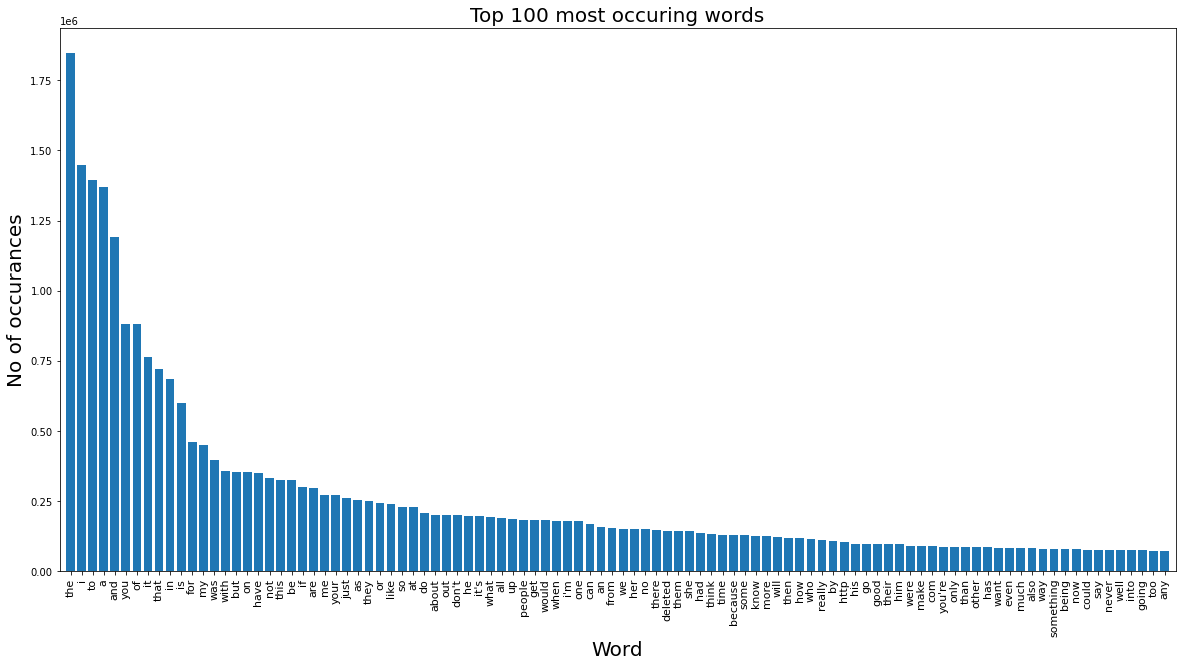

In [55]:
# Plot the results

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

counts = [x[1] for x in data]
words = [x[0] for x in data]
figure(figsize=(20,10))
index = np.arange(len(words))
plt.bar(index, counts)
plt.xlabel('Word', fontsize=20)
plt.ylabel('No of occurances', fontsize=20)
plt.xticks(index, words, fontsize=11, rotation=90)
plt.title('Top 100 most occuring words', fontsize=20)
plt.xlim([-1,100])
plt.show()

In [5]:
# Print out the runtime to be able to perform scalability tests
print(runtime)

106.68684530258179


In [6]:
# End spark session
spark_context.stop()